In [3]:
import torch
import unicodedata
import torch.nn as nn 
import matplotlib.pyplot as plt 
from IPython.display import Image
import io
import os
import string
import glob
import torch
import random

## Some functions to work on files and strings

##### parametr

In [4]:
CHARACTER = string.ascii_letters + ' ' + '.' + ',' + ';' + "'"
Len_Character = len(CHARACTER)
hid_len = 200
Alph = 0.0055
current_loss = 0
Collection_of_losses = []
num = 150000
local_loss = 0
Len_Character

57

In [92]:
def cnvrt_acti(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in CHARACTER
    )

##### Data: https://download.pytorch.org/tutorial/data.zip

In [111]:
def LoadData():
    Country_dict = {};All_Country = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [cnvrt_acti(line) for line in lines]

    for filename in find_files('*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        All_Country.append(category)
        lines = read_lines(filename)
        Country_dict[category] = lines
        
    return Country_dict, All_Country

In [94]:
def FindInex(letter):
    return CHARACTER.find(letter)

## One Hot Encoding

In [95]:
def oneHot_tensor(line):
    tensor = torch.zeros(len(line), 1, Len_Character)
    for i, letter in enumerate(line):
        tensor[i][0][FindInex(letter)] = 1
    return tensor

In [96]:
def Random(Country_dict, All_Country):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(All_Country)
    line = random_choice(Country_dict[category])
    category_tensor = torch.tensor([All_Country.index(category)], dtype=torch.long)
    line_tensor = oneHot_tensor(line)
    return category, line, category_tensor, line_tensor

# RNN

In [100]:
class RNN(nn.Module):
    def __init__(self, inp_len, hid_len, out_len):
        super(RNN, self).__init__()
        
        self.hid_len = hid_len
        self.i2h = nn.Linear(inp_len + hid_len, hid_len)
        self.i2o = nn.Linear(inp_len + hid_len, out_len)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        
        combined = torch.hstack((input_tensor, hidden_tensor))
        hidden = self.i2h(combined)
        out = self.softmax(self.i2o(combined))
        
        return out, hidden
    
    def CrtZero(self):
        return torch.zeros(1, self.hid_len)

In [101]:
Country_dict, All_Country = LoadData()
All_Country

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [102]:
Sample = RNN(Len_Character, hid_len, len(All_Country))

In [103]:
def GetResult(output):
    category_idx = torch.argmax(output).item()
    return All_Country[category_idx]

In [104]:
detriment = nn.NLLLoss()
optimizer = torch.optim.SGD(Sample.parameters(), lr=Alph)

In [105]:
def TrainingModel(line_tensor, category_tensor):

    hidden = Sample.CrtZero()
    for i in range(line_tensor.size()[0]):
        output, hidden = Sample(line_tensor[i], hidden)
        
    ls = detriment(output, category_tensor)
    ls.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    return output, ls.item()

In [106]:

for i in range(num):

    country, line, category_tensor, line_tensor = Random(Country_dict, All_Country)
    prd, loss = TrainingModel(line_tensor, category_tensor)
    
    local_loss += loss 
    
    if (i+1) % 5000 == 0:

        Collection_of_losses.append(local_loss / 1000)
        local_loss = 0
        
    if (i+1) % 7000 == 0:
        guess = GetResult(prd)

        if guess == country:
            correct = "Correct Answer."
        else:
            correct = "Wrong Answer!!"  

        print(i , '. ' , "loss = " , f"{loss:.4f}   {line} - {guess} , {correct}")

6999 .  loss =  1.5886   Jeon - Korean , Correct Answer.
13999 .  loss =  1.5502   Finnegan - Irish , Correct Answer.
20999 .  loss =  1.2292   Rahal - Vietnamese , Wrong Answer!!
27999 .  loss =  1.2123   Kalogeria - Greek , Correct Answer.
34999 .  loss =  1.4392   Inouye - Japanese , Correct Answer.
41999 .  loss =  1.2256   Bonaventura - Portuguese , Wrong Answer!!
48999 .  loss =  1.4080   Mckee - English , Correct Answer.
55999 .  loss =  0.6250   Nasledov - Russian , Correct Answer.
62999 .  loss =  0.0984   Thao - Vietnamese , Correct Answer.
69999 .  loss =  0.8144   Waclauska - Czech , Correct Answer.
76999 .  loss =  2.4370   Dupond - German , Wrong Answer!!
83999 .  loss =  0.1344   Pispinis - Greek , Correct Answer.
90999 .  loss =  4.0841   Smit - Korean , Wrong Answer!!
97999 .  loss =  0.8880   Ganim - Arabic , Correct Answer.
104999 .  loss =  0.6631   Shao - Chinese , Correct Answer.
111999 .  loss =  0.2432   Fujishima - Japanese , Correct Answer.
118999 .  loss =  0

### Draw diagram


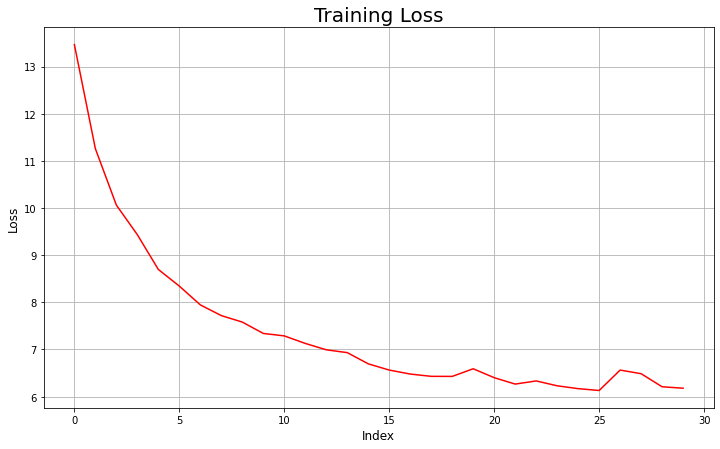

In [107]:
plt.figure(figsize=(12, 7))
plt.plot(Collection_of_losses, color='red')
plt.title('Training Loss', fontsize=20)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()

In [110]:
while True:
    ph = input("Do you want to continue or is it over? If you want to continue, enter Yes, otherwise it will end = ")
    if ph=="Yes":
        with torch.no_grad():
            input_line = input("Input Name :")

            line_tensor = oneHot_tensor(input_line)
            hidden = Sample.CrtZero()
            
            for i in range(line_tensor.shape[0]):
                output, hidden = Sample(line_tensor[i], hidden)
            
            res = GetResult(output)
            print("Input ",input_line," , result :", res)
    else:
        print("Bye.")
        break

Input  Armbrüster  , result : German
Input  Bao  , result : Chinese
Input  Naifeh  , result : Arabic
Input  Ali  , result : Italian
Input  Abraham  , result : Vietnamese
Input  Akutagawa  , result : Japanese
Input  Chikamatsu  , result : Japanese
Input  Han  , result : Chinese
Input  Abbracciabeni  , result : Italian
Input  Acqua  , result : Portuguese
Input  Nader  , result : Arabic
Input  Ghanem  , result : Arabic
Input  Abakshin  , result : Russian
Input  Bischoffs  , result : English
Input  Adderley  , result : English
Input  Gerig  , result : German
Bye.
